In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [4]:
result_i3d = pd.DataFrame()
result_r21d = pd.DataFrame()
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    file_name_i3d = 'test-i3d-run_01/result-%d.csv' % (i)
    file_name_r21d = 'test-r21d-run_01/result-%d.csv' % (i)
    read_i3d = pd.read_csv(file_name_i3d, index_col=0)
    read_r21d = pd.read_csv(file_name_r21d, index_col=0)
    result_i3d = pd.concat([result_i3d, read_i3d], ignore_index=True)
    result_r21d = pd.concat([result_r21d, read_r21d], ignore_index=True)
print(result_i3d.shape)
print(result_r21d.shape)

(285691, 17)
(285691, 17)


In [8]:
i3d_rgb_out = result_i3d.iloc[:,0:8]
i3d_flow_out = result_i3d.iloc[:,8:16]
i3d_labels = result_i3d.iloc[:,16]
r21d_rgb_out = result_r21d.iloc[:,0:8]
r21d_flow_out = result_r21d.iloc[:,8:16]
r21d_labels = result_r21d.iloc[:,16]

print(i3d_rgb_out.head())
print(r21d_rgb_out.head())
print(i3d_flow_out.head())
print(r21d_flow_out.head())
print(sum(r21d_labels==i3d_labels))

         r1         r2        r3        r4        r5        r6        r7  \
0 -0.795741  10.239339 -0.412855 -4.944712 -2.480436  5.252425 -6.714810   
1 -1.127811  11.179989  0.134118 -5.033363 -1.108556  3.778624 -5.803679   
2 -1.432058  11.447810 -0.747062 -5.168765 -2.358906  6.018133 -7.150262   
3  0.119476  14.565108  0.216638 -5.108922 -1.045167  4.410847 -6.036085   
4  0.399822  15.352140 -0.933121 -4.512376 -1.373816  4.295237 -6.937357   

         r8  
0 -4.623600  
1 -4.072296  
2 -4.506099  
3 -5.229732  
4 -5.622418  
         r1        r2        r3        r4        r5        r6        r7  \
0  1.950235  6.403010 -1.896819 -2.895360 -2.167584 -0.743972 -3.131170   
1  1.356184  6.912596 -2.043621 -2.859473 -2.220793 -0.826882 -3.353245   
2  0.977449  8.258120 -2.262155 -3.060124 -2.395120 -1.198090 -3.982778   
3  0.729560  8.059046 -2.099241 -2.951845 -2.377089 -1.267875 -3.866491   
4  0.590667  8.139771 -1.995464 -3.035907 -2.310025 -1.329578 -4.008851   

        

In [11]:
i3d_mixed = []
r21d_mixed = []
flow_weight = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for weight in range(11):
    i3d_mixed.append(np.asarray(i3d_rgb_out)*(1-flow_weight[weight]) + np.asarray(i3d_flow_out)*flow_weight[weight])
    r21d_mixed.append(np.asarray(r21d_rgb_out)*(1-flow_weight[weight]) + np.asarray(r21d_flow_out)*flow_weight[weight])
print(i3d_mixed[0].shape)
print(r21d_mixed[0].shape)

(285691, 8)
(285691, 8)


In [12]:
i3d_sm = []
r21d_sm = []
for weight in range(11):
    tmp = []
    for i in range(i3d_mixed[weight].shape[0]):
        tmp.append(softmax(i3d_mixed[weight][i]))
    i3d_sm.append(np.asarray(tmp))
    r_tmp = []
    for i in range(r21d_mixed[weight].shape[0]):
        r_tmp.append(softmax(r21d_mixed[weight][i]))
    r21d_sm.append(np.asarray(r_tmp))
print(i3d_sm[0].shape)
print(r21d_sm[0].shape)

(285691, 8)
(285691, 8)


In [14]:
from sklearn.metrics import accuracy_score

i3d_class_acc = []
r21d_class_acc = []
for i in range(8):
    acc = []
    for weight in range(11):
        acc.append(accuracy_score(i3d_labels[i3d_labels==i], i3d_sm[weight][i3d_labels==i].argmax(axis=1)))
    i3d_class_acc.append(acc)
    r_acc = []
    for weight in range(11):
        r_acc.append(accuracy_score(r21d_labels[r21d_labels==i], r21d_sm[weight][r21d_labels==i].argmax(axis=1)))
    r21d_class_acc.append(r_acc)
print(len(i3d_class_acc[0]))
print(len(r21d_class_acc[0]))

11
11


In [31]:
r21d_class_acc[6]
np.asarray(np.arange(0,10))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [36]:
accuracies = []
for i in range(8):
    i3d_result_acc = pd.DataFrame({'accuracy':i3d_class_acc[i],'model':'i3d','flow_weight':flow_weight})
    r21d_result_acc = pd.DataFrame({'accuracy':r21d_class_acc[i],'model':'r(2+1)d','flow_weight':flow_weight})
    result_acc = pd.concat([i3d_result_acc, r21d_result_acc], ignore_index=True)
    accuracies.append(result_acc)

In [43]:
type(accuracies[2])

pandas.core.frame.DataFrame

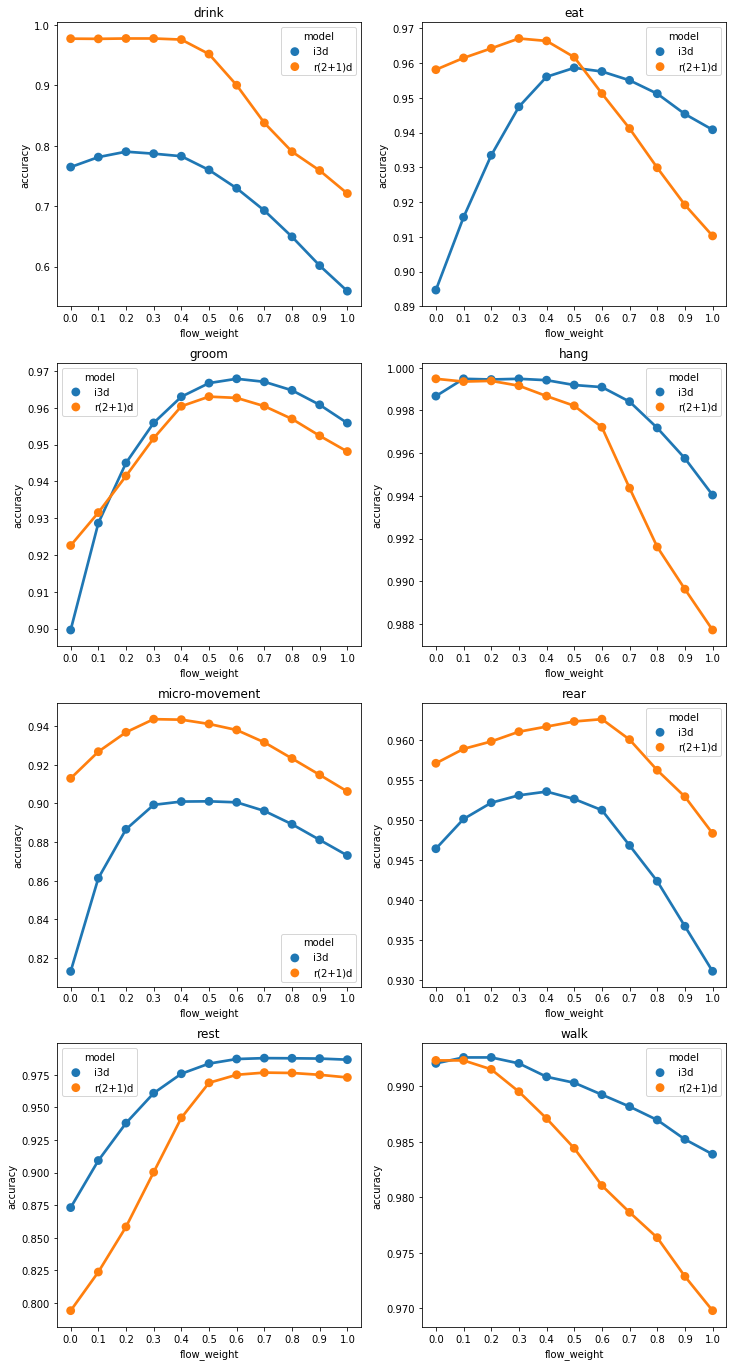

In [53]:
class_labels = ['drink', 'eat', 'groom', 'hang', 'micro-movement', 'rear', 'rest', 'walk']
f,ax=plt.subplots(4,2,figsize=(12,24))
for i in range(8):
    sns.pointplot('flow_weight','accuracy',hue='model',data=accuracies[i],ax=ax[int(i/2),i%2])
    ax[int(i/2),i%2].set_title(class_labels[i])
#plt.close(8)
f.savefig('class_acc.pdf', bbox_inches='tight')
plt.show()

0.7646176911544228


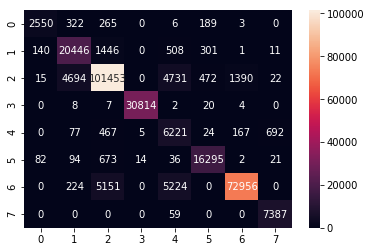

In [10]:
from sklearn.metrics import confusion_matrix
cfm = confusion_matrix(labels, sm[0].argmax(axis=1))
print(cfm[0][0]/cfm[0].sum())
sns.heatmap(cfm, annot=True, fmt='d')

In [11]:
print(labels.shape)
sum = 0
for i in range(8):
    print(len(labels[labels==i]))
    sum+=len(labels[labels==i])
sum

(285691,)
3335
22853
112777
30855
7653
17217
83555
7446


285691

In [12]:
sm[0].argmax(axis=1)
sm[0][1]

array([4.51350899e-06, 9.99364541e-01, 1.59427472e-05, 9.08562126e-08,
       4.60125686e-06, 6.10031074e-04, 4.20543015e-08, 2.37542172e-07])

In [24]:
num_frames = labels.value_counts()
num_frames[sorted(num_frames.index)]

0      3335
1     22853
2    112777
3     30855
4      7653
5     17217
6     83555
7      7446
Name: label, dtype: int64

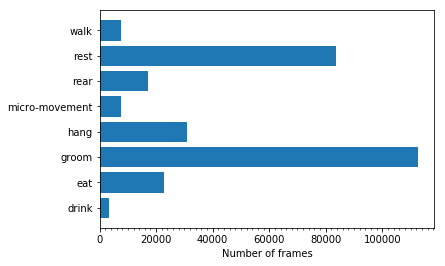

In [65]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
majorLocator = MultipleLocator(10000)
minorLocator = MultipleLocator(2000)
fig, ax = plt.subplots()
#ax.yaxis.set_major_formatter(formatter)
ax.barh(num_frames.index, num_frames.values)
ax.set_xlabel("Number of frames")
plt.yticks(sorted(num_frames.index), ('drink', 'eat', 'groom', 'hang', 'micro-movement', 'rear', 'rest', 'walk'))
plt.xticks()
#x.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_minor_locator(minorLocator)
plt.show()
fig.savefig('num_frames.pdf', bbox_inches='tight')

In [ ]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot('SibSp','Survived',data=data,ax=ax[0])
ax[0].set_title('SibSp vs Survived')
sns.factorplot('SibSp','Survived',data=data,ax=ax[1])
ax[1].set_title('SibSp vs Survived')
plt.close(2)
plt.show()